# Trend Filtering Methods for Momentum Trading Strategies

### We have implemented the following trend filtering methods:

### 1. L2 Filter (H-P Filter)
### 2. L1 filter
### 3. Wavelet Filtering
### 4. Moving average
### 5. Moving average crossover
### 6. Enhanced Filters: Triangular window , Asymmetric, Lanczos
### 7. Lowess Regression
### 8. Kernel Regression
### 9. Gaussian Regression


### Input Data: BTC-USD

### Date range for data: 5Y (2016-12-01 to 2021-12-01)

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import cvxpy 
import scipy
import cvxopt 
import matplotlib.pyplot as plt
import yfinance as yf

from numpy.linalg import inv
from scipy.fftpack import rfft, irfft, fftfreq, fft
from scipy.ndimage import convolve1d
from moepy import lowess
from scipy.stats import gaussian_kde
from scipy import interpolate, ndimage
from Historic_Crypto import HistoricalData

In [2]:
# Get the bitcoin-usd daily data between 2016-12-01 and 2021-12-01

data = HistoricalData('BTC-USD',86400,'2016-12-01-00-00','2021-12-01-00-00').retrieve_data()

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2016-12-01T00:00:00
Provisional End: 2017-09-27T00:00:00
Data for chunk 1 of 7 extracted
Provisional Start: 2017-09-27T00:00:00
Provisional End: 2018-07-24T00:00:00
Data for chunk 2 of 7 extracted
Provisional Start: 2018-07-24T00:00:00
Provisional End: 2019-05-20T00:00:00
Data for chunk 3 of 7 extracted
Provisional Start: 2019-05-20T00:00:00
Provisional End: 2020-03-15T00:00:00
Data for chunk 4 of 7 extracted
Provisional Start: 2020-03-15T00:00:00
Provisional End: 2021-01-09T00:00:00
Data for chunk 5 of 7 extracted
Provisional Start: 2021-01-09T00:00:00
Provisional End: 2021-11-05T00:00:00
Data for chunk 6 of 7 extracted
Provisional Start: 2021-11-05T00:00:00
Provisional End: 2022-09-01T00:00:00
Data for chunk 7 of 7 extracted


In [3]:
y = data['close'].to_numpy()

dates = data.index
# Taking the log of prices

y = np.log(y)
n = y.size
ones_row = np.ones((1, n))

# Creating matrix D

D = scipy.sparse.spdiags(np.vstack((ones_row, -2*ones_row, ones_row)), range(3), n-2, n)

# H-P/L-2 Filter

In [4]:
# Use different values of lambda to observe the changes in objective function value and the resulting trend

lambda_list = [0, 0.1, 0.5, 1, 2, 5, 10, 50, 200, 500, 1000, 2000, 5000, 10000, 100000]

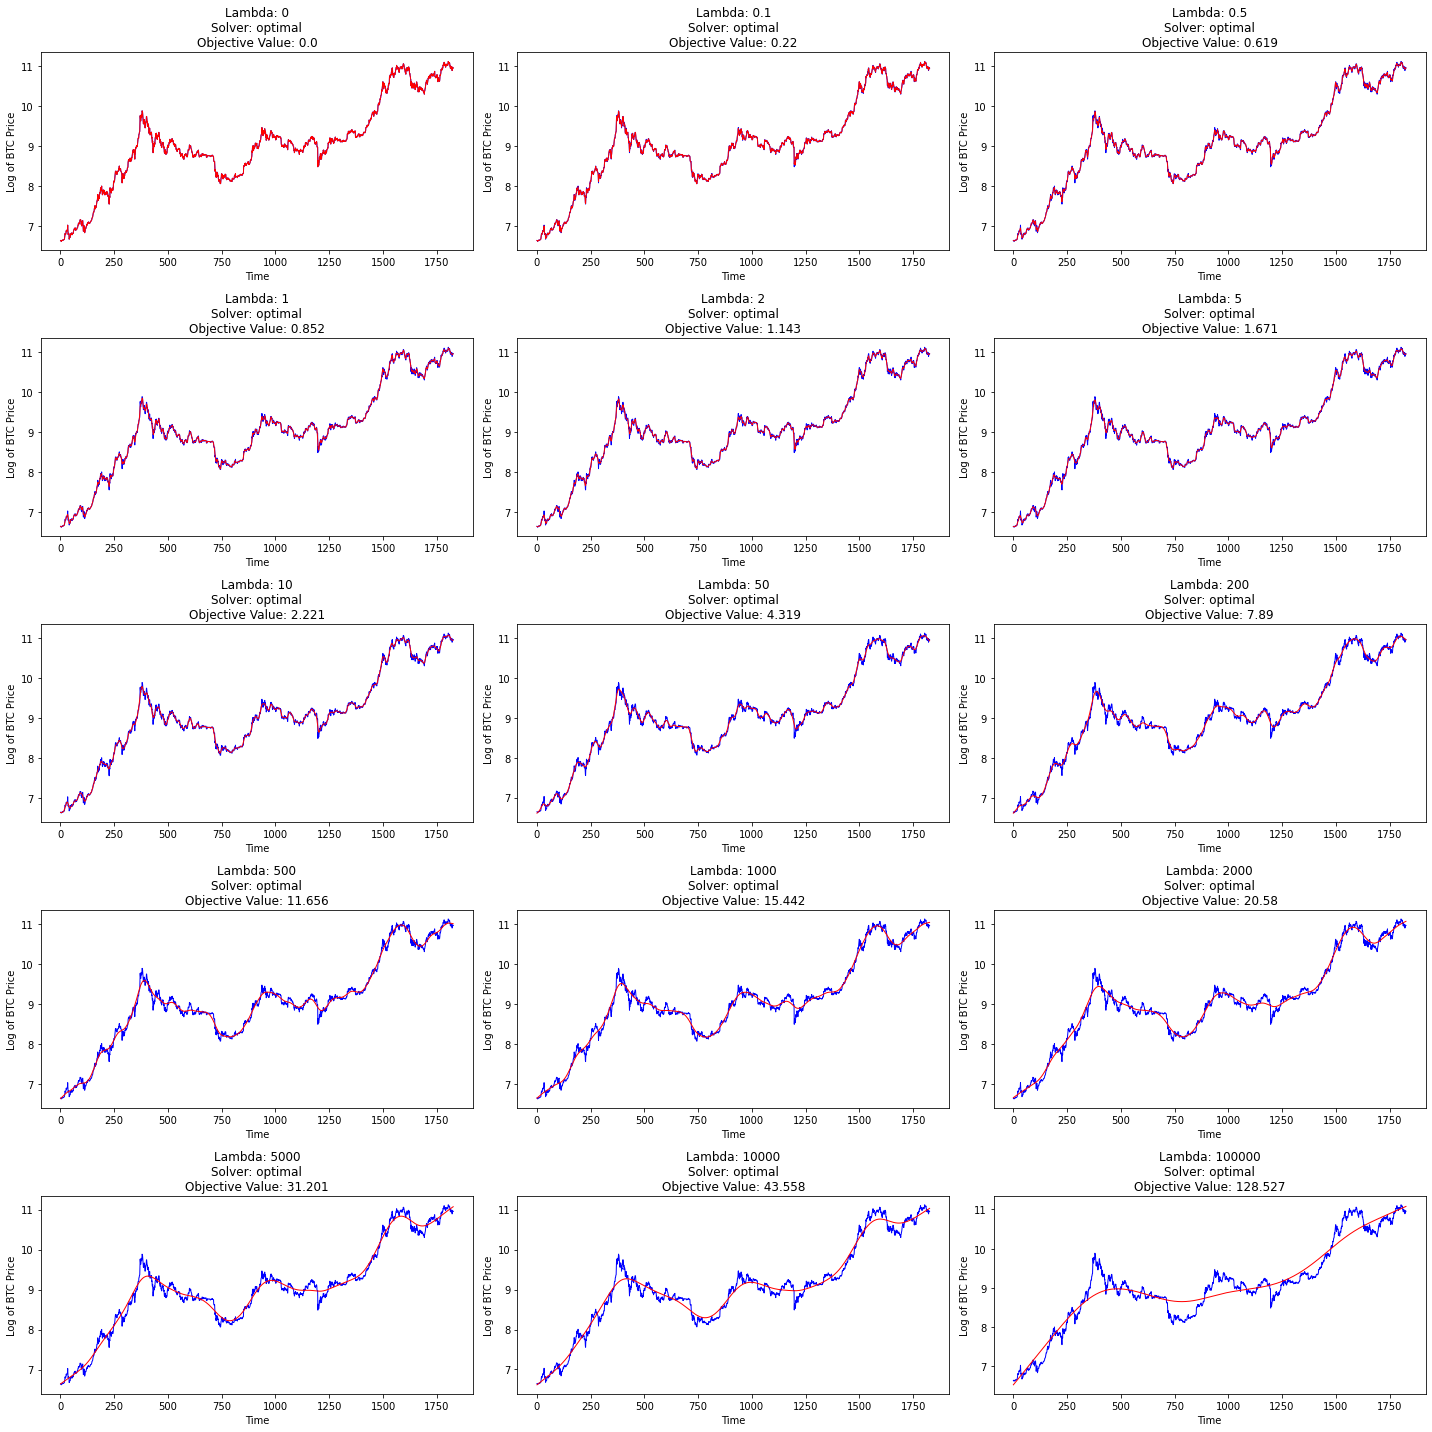

In [5]:
solver = cvxpy.CVXOPT

# L-2 Norm
reg_norm = 2
fig, ax = plt.subplots(len(lambda_list)//3, 3, figsize=(20,20))
ax = ax.ravel()
ii = 0

for lambda_value in lambda_list:
    x = cvxpy.Variable(shape=n) 
    # x is the filtered trend that we initialize
    objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(y-x) 
                  + lambda_value * cvxpy.norm(D@x, reg_norm))
   
    # D@x is syntax for matrix multiplication
    problem = cvxpy.Problem(objective)
    problem.solve(solver=solver)
    ax[ii].plot(np.arange(1, n+1), y, linewidth=1.0, c='b')
    ax[ii].plot(np.arange(1, n+1), np.array(x.value), linewidth=1.0, c='r')
    ax[ii].set_xlabel('Time')
    ax[ii].set_ylabel('Log of BTC Price')
    ax[ii].set_title('Lambda: {}\nSolver: {}\nObjective Value: {}'.format(lambda_value, problem.status, round(objective.value, 3)))
    ii+=1
    
plt.tight_layout()
plt.show()

## L-1 Filter

### Optimal Lambda

In [6]:
lambda_max = np.linalg.norm(inv(D@np.transpose(D.toarray()))@(D@y),ord=np.inf)

In [7]:
print(lambda_max)

42654.04577767756


### Generate the trend for different values of lambda, including lambda max

In [8]:
# Use different values of lambda to observe the changes in objective function value and the resulting trend

lambda_list = [0, 0.5, 1, 10, 50, 200, 500, 1000, 2000, 5000, 10000, 30000, 42654, 50000, 100000]

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1295: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1295: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1295: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


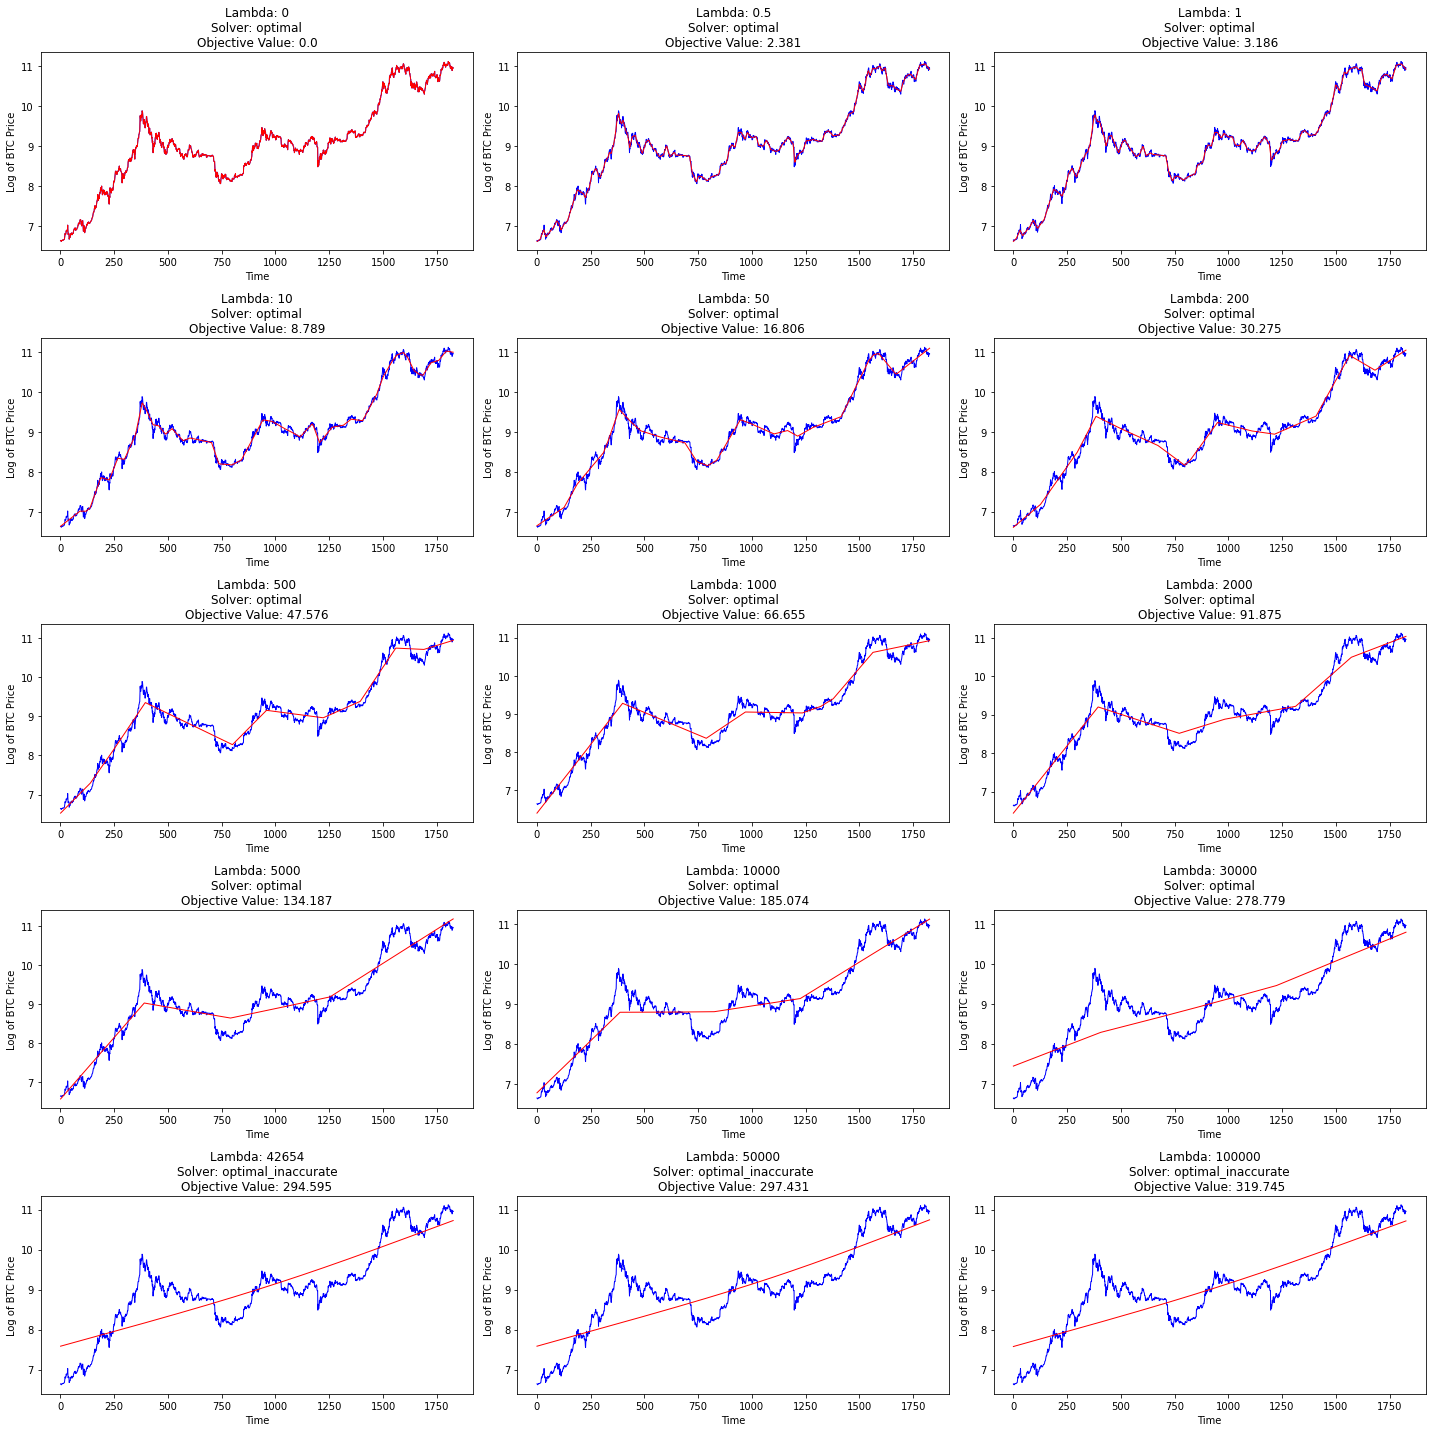

In [9]:
# Using similar list of different lambda values as above, observe the changes in objective function value and the resulting trend

solver = cvxpy.ECOS

# L-1 Norm
reg_norm = 1

fig, ax = plt.subplots(len(lambda_list)//3, 3, figsize=(20,20))
ax = ax.ravel()
ii = 0

for lambda_value in lambda_list:
    x = cvxpy.Variable(shape=n) 
    # x is the filtered trend that we initialize
    objective = cvxpy.Minimize(0.5 * cvxpy.sum_squares(y-x) 
                  + lambda_value * cvxpy.norm(D@x, reg_norm))

    problem = cvxpy.Problem(objective)
    
    # Increased the maximum solver iterations
    
    problem.solve(solver=solver, max_iters=10000)
    ax[ii].plot(np.arange(1, n+1), y, linewidth=1.0, c='b')
    ax[ii].plot(np.arange(1, n+1), np.array(x.value), linewidth=1.0, c='r')
    ax[ii].set_xlabel('Time')
    ax[ii].set_ylabel('Log of BTC Price')
    ax[ii].set_title('Lambda: {}\nSolver: {}\nObjective Value: {}'.format(lambda_value, problem.status, round(objective.value, 3)))
    ii+=1
    
plt.tight_layout()
plt.show()

### Observations:

#### We can observe that for larger values of lambda (also for our calculated value of lambda max), the solver returns the status 'optimal_inaccurate'. 

#### This indicates that the solver called by the CVXPY library solves the problem but to a lower accuracy than desired,  and the problem status shows the lower accuracy achieved. 

## Wavelet Filtering

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Spectrum of the signal')

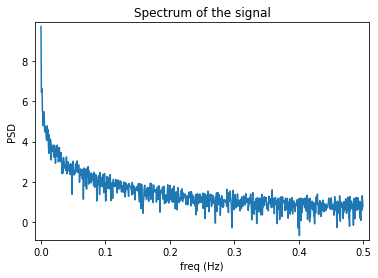

In [10]:
f = fftfreq(n)

# Compute power spectral density
y_freq_domain = fft(y)
y_freq_domain_real = rfft(y)

# Generate a plot
plt.plot(f[(f>=0)], np.log(y_freq_domain[(f>=0)]))
plt.xlabel('freq (Hz)')
plt.ylabel('PSD')
plt.margins(0.02)
plt.title('Spectrum of the signal')

In [11]:
# Wavelet filtering: 99% and 95% respectively
p99 = 0.01*max(f)
p95 = 0.05*max(f)

cut_f_signal = y_freq_domain_real
cut_f_signal[(f>p95)] = 0  # filter all frequencies above 0.6
cut_signalp95 = irfft(cut_f_signal)

cut_f_signal[(f>p99)] = 0  # filter all frequencies above 0.6
cut_signalp99 = irfft(cut_f_signal)

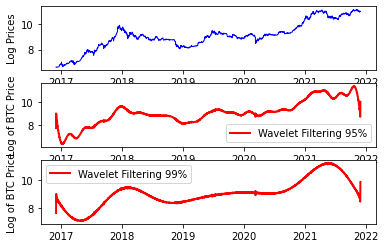

In [12]:
# Generate plots

fig = plt.figure()
ax1 = fig.add_subplot(311,  ylabel='Log of BTC Price')
ax2 = fig.add_subplot(312,  ylabel='Log of BTC Price')
ax3 = fig.add_subplot(313,  ylabel='Log of BTC Price')


ax1.plot(dates, y, linewidth=1.0, c='b')



line1, = ax2.plot(dates, np.array(cut_signalp95), linewidth=2.0, c='r')
line2, = ax3.plot(dates, np.array(cut_signalp99), linewidth=2.0, c='r')

ax2.legend([line1], [f'Wavelet Filtering 95%'])
ax3.legend([line2], [f'Wavelet Filtering 99%'])

ax1.set_xlabel('Time')
ax1.set_ylabel('Log Prices')
plt.show()

# Moving Averages

In [13]:
# Calculate moving average

def mvng_avg(x, w):
    av = []
    for i in range(x.shape[0]):
        if i>w:
            av.append(np.sum(x[i-w:i])/w)
        else:
            av.append(np.sum(x[:i])/i)
    return np.array(av)

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


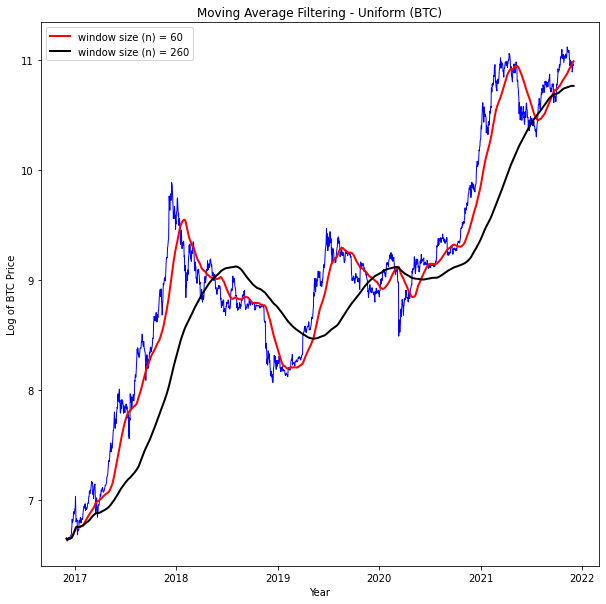

In [14]:
# Generate plots with window 1 size as 60 and window 2 size as 260

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')
w1 = 60
w2 = 260
avg1 = mvng_avg(y,w1)
avg2 = mvng_avg(y,w2)

line1, = plt.plot(dates, np.array(avg1), linewidth=2.0, c='r')
line2, = plt.plot(dates, np.array(avg2), linewidth=2.0, c='black')

plt.legend([line1,line2], [f'window size (n) = {w1}',f'window size (n) = {w2}'])
plt.xlabel('Year')
plt.ylabel('Log of BTC Price')
plt.title('Moving Average Filtering - Uniform (BTC)')
plt.show()

### Moving Average Crossover

In [15]:
trend = 2*(avg1-avg2)/(w2-w1)

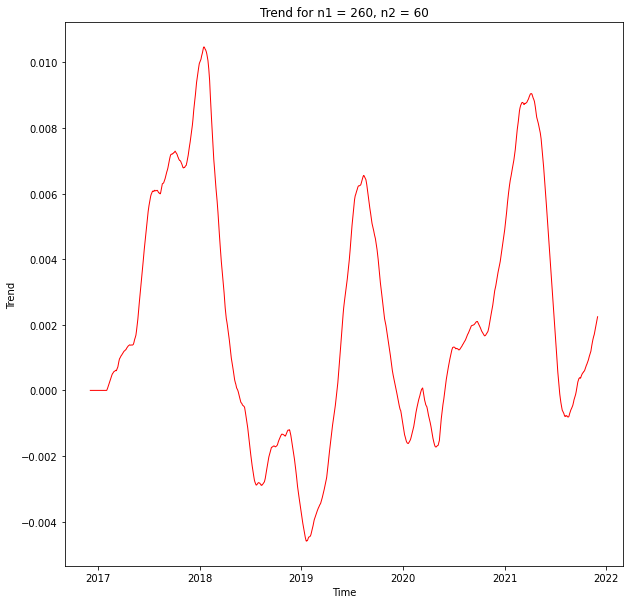

In [16]:
# Generate a plot with differences between the two moving averages

plt.plot(dates, np.array(trend), linewidth=1.0, c='r')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.title('Trend for n1 = 260, n2 = 60')
plt.show()

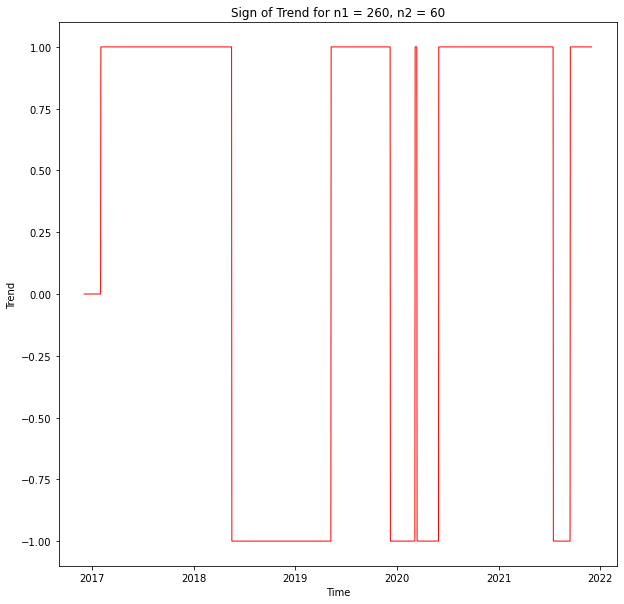

In [17]:
# Calculate and plot sign of the trend

plt.plot(dates, np.sign(np.array(trend)), linewidth=1.0, c='r')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.title('Sign of Trend for n1 = 260, n2 = 60')
plt.show()

### Enhanced Filters: Triangular window , Asymmetric, Lanczos

In [18]:
def apply_window(x,window):
    return convolve1d(x,window)

In [19]:
# Window 1 size is 260 and Window 2 size is 60

w1 = 260
w2 = 60
peak = 2/(w1-1)
window = np.append(np.linspace(0,peak,w2),np.linspace(peak,0,w1-w2+1)[1:])

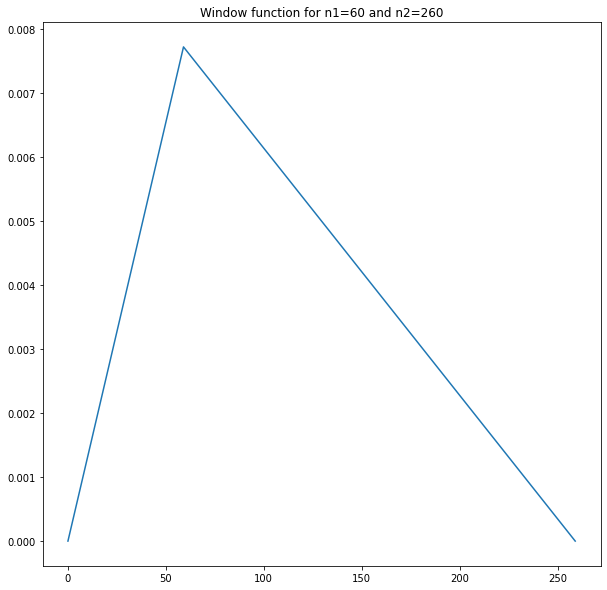

In [20]:
# Generate plots for triangular window

plt.plot(window)
plt.title("Window function for n1=60 and n2=260")
plt.show()

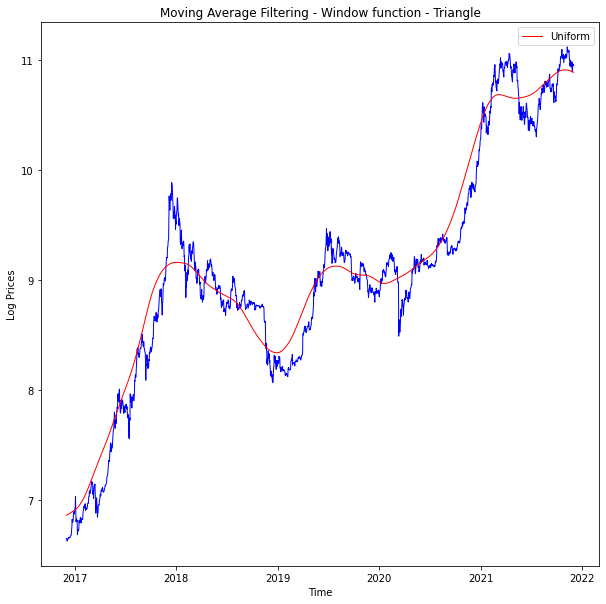

In [21]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')

avg1 = apply_window(y,window)

line1, = plt.plot(dates, np.array(avg1), linewidth=1.0, c='r')

plt.legend([line1], [f'Uniform'])
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Moving Average Filtering - Window function - Triangle')
plt.show()

##  Moving averages : Triangular Window

In [22]:
# Window size is 260

w = 260
a = np.linspace(0,w-1,w)

In [23]:
window = 4*((w/2)-np.absolute(w/2-a))/w**2

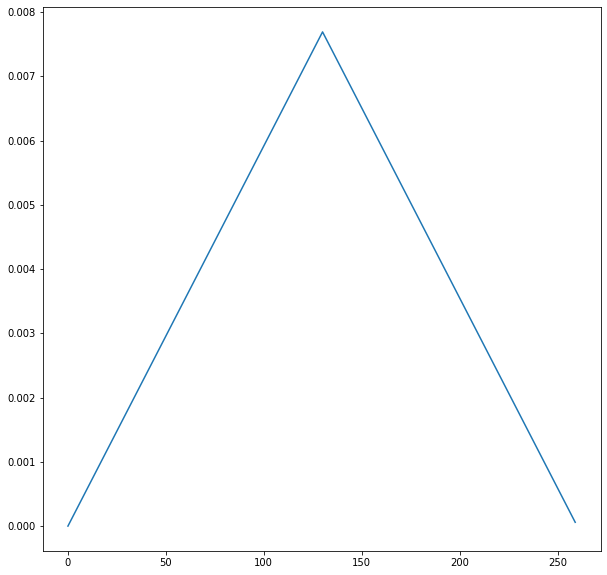

In [24]:
plt.plot(window)

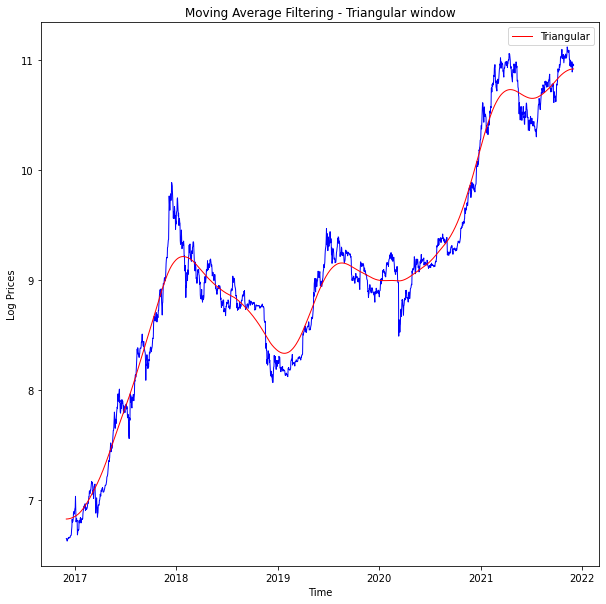

In [25]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')

avg1 = apply_window(y,window)

line1, = plt.plot(dates, np.array(avg1), linewidth=1.0, c='r')

plt.legend([line1], [f'Triangular'])
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Moving Average Filtering - Triangular window')
plt.show()

## Moving Averages : Assymetric Window function

In [26]:
w = 260
a = np.linspace(0,w-1,w)

window = 2*((w-a))/w**2

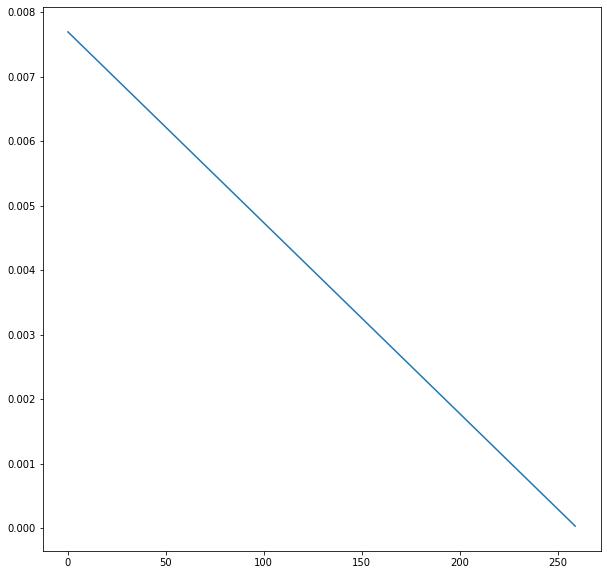

In [27]:
plt.plot(window)

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  


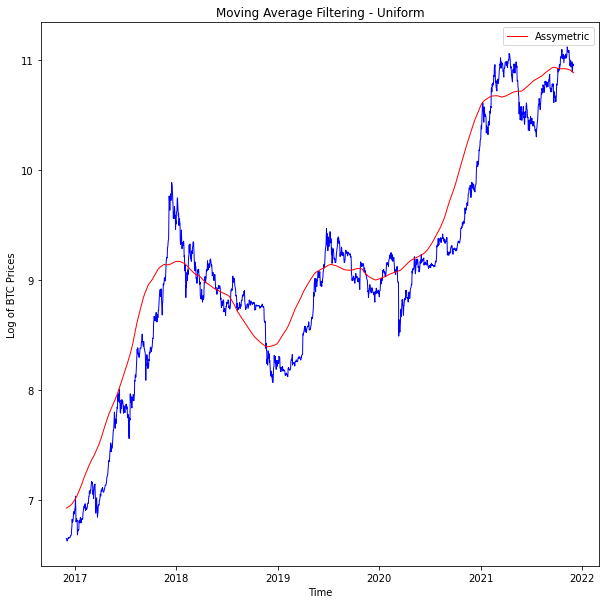

In [28]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')

avg1 = apply_window(y,window)

line1, = plt.plot(dates, np.array(avg1), 'b-', linewidth=1.0, c='r')

plt.legend([line1], [f'Assymetric'])
plt.xlabel('Time')
plt.ylabel('Log of BTC Prices')
plt.title('Moving Average Filtering - Uniform')
plt.show()

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  


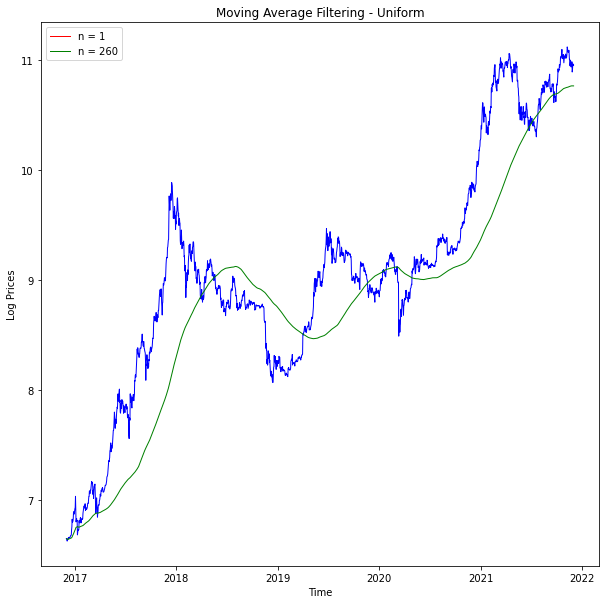

In [29]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')
w1 = 1
w2 = 260
avg1 = mvng_avg(y,w1)
avg2 = mvng_avg(y,w2)

line2, = plt.plot(dates, np.array(avg2), 'b-', linewidth=1.0, c='g')

plt.legend([line1,line2], [f'n = {w1}',f'n = {w2}'])
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Moving Average Filtering - Uniform')
plt.show()

In [30]:
trend = 2*(avg1-avg2)/(w2-w1)

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  """Entry point for launching an IPython kernel.


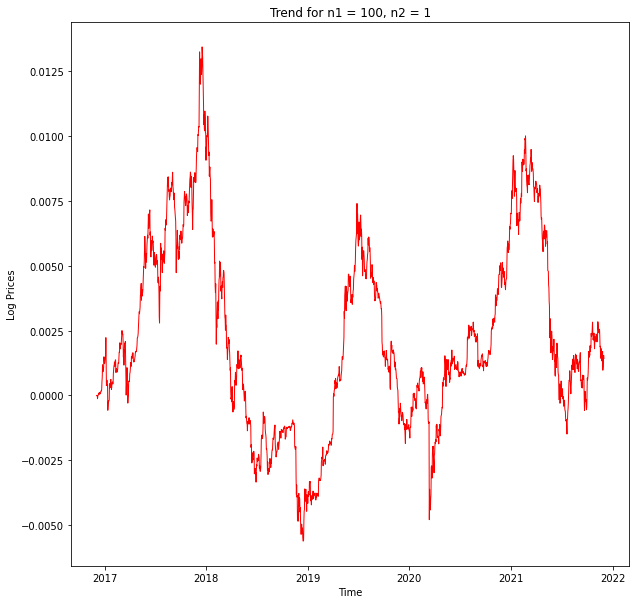

In [31]:
plt.plot(dates, np.array(trend), 'b-', linewidth=1.0, c='r')
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Trend for n1 = 100, n2 = 1')
plt.show()

## Lanczos Filter

In [32]:
w = 260
a = np.linspace(0,w-1,w)

window = 6*(a*(w-a))/w**3

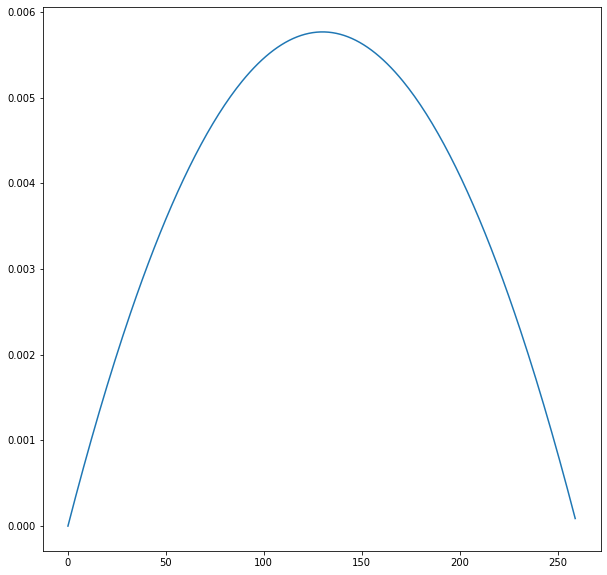

In [33]:
plt.plot(window)

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  


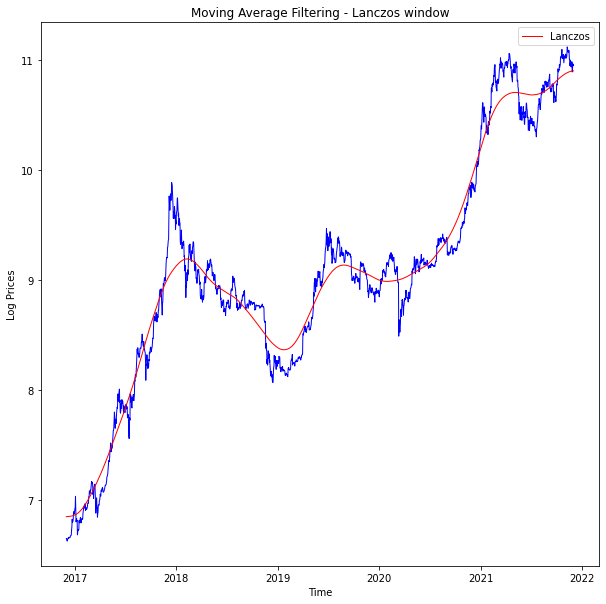

In [34]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')

avg1 = apply_window(y,window)

line1, = plt.plot(dates, np.array(avg1), 'b-', linewidth=1.0, c='r')

plt.legend([line1], [f'Lanczos'])
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Moving Average Filtering - Lanczos window')
plt.show()

# Non Linear Models

## Lowess regression

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.


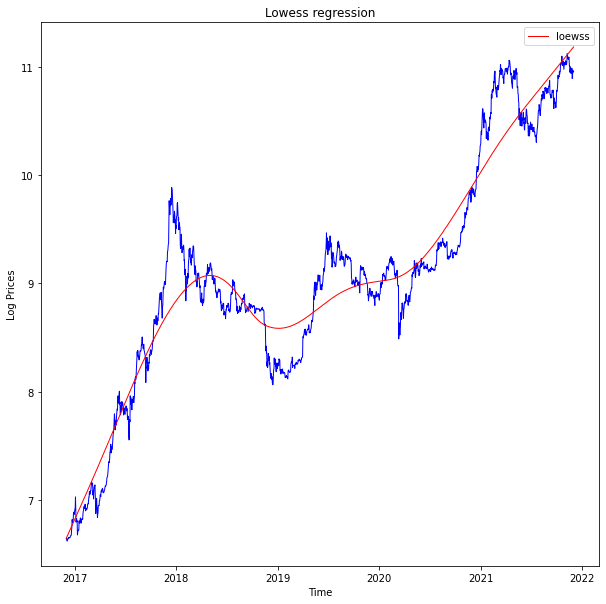

In [35]:
# Data generation
x = np.linspace(0, n,n)

# Model fitting
lowess_model = lowess.Lowess()
lowess_model.fit(x, y,robust_iters=0)

# Model prediction
x_pred = np.linspace(0, n,n)
y_pred = lowess_model.predict(x_pred)



plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')


line1, = plt.plot(dates, np.array(y_pred), 'b-', linewidth=1.0, c='r')

plt.legend([line1], [f'loewss'])
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Lowess regression')
plt.show()

## Kernel Regression

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.


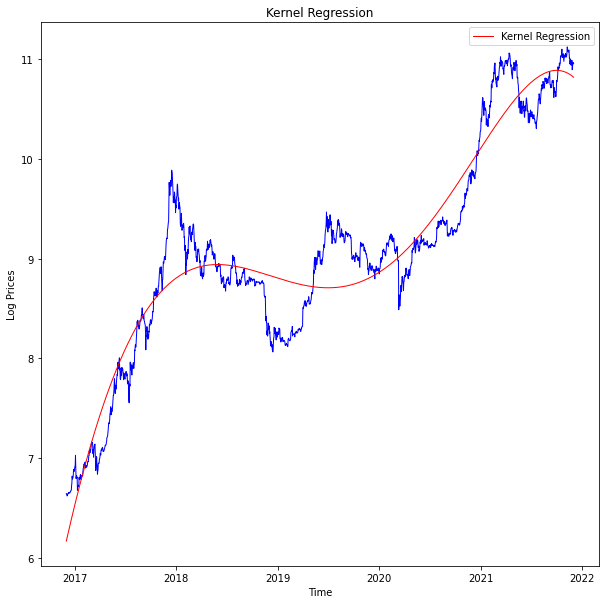

In [36]:
# Data generation
x = np.linspace(0, n,n)

# Model fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(x.reshape(-1,1))
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

# Model prediction
x_pred = np.linspace(0, n,n)
X_poly = poly_reg.fit_transform(x_pred.reshape(-1,1))
y_pred = pol_reg.predict(X_poly)

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')

line1, = plt.plot(dates, np.array(y_pred), 'b-', linewidth=1.0, c='r')

plt.legend([line1], [f'Kernel Regression'])
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Kernel Regression')
plt.show()

/Users/bhumikaekbote/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app


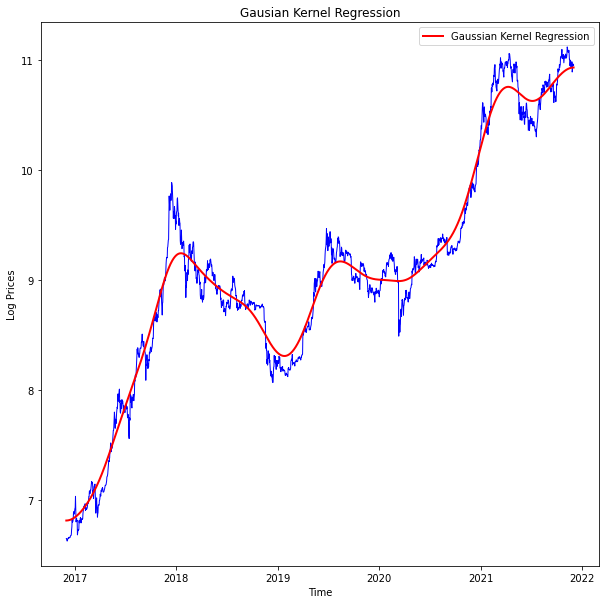

In [37]:
# Data generation
x = np.linspace(0, n,n)

# Model fitting

sigma = 50
y_pred = ndimage.gaussian_filter1d(y, sigma)



plt.rcParams["figure.figsize"] = (10,10)
plt.plot(dates, y, linewidth=1.0, c='b')


line1, = plt.plot(dates, np.array(y_pred), 'b-', linewidth=2.0, c='r')

plt.legend([line1], [f'Gaussian Kernel Regression'])
plt.xlabel('Time')
plt.ylabel('Log Prices')
plt.title('Gausian Kernel Regression')
plt.show()